# Tutaj mamy ładny przykład dla jednego learning rate 1e-2, jak rożnie nam się metody zbiegają dla 1000 kroków dla danego x0=(1.5, -1.5)

/tmp/ipykernel_17566/4092742357.py:13: RuntimeWarning: overflow encountered in double_scalars
  dX = -2*(a - X) - 4*b*X*(Y - X**2)
/tmp/ipykernel_17566/4092742357.py:14: RuntimeWarning: overflow encountered in double_scalars
  dY =  2*b*(Y - X**2)


Start x0 = (1.5, -1.5)
GD       : x_end=( nan,  nan)  f= nan
SGD      : x_end=( nan,  nan)  f= nan
Momentum : x_end=( nan,  nan)  f= nan
Nesterov : x_end=( nan,  nan)  f= nan
RMSProp  : x_end=( 0.649911,  0.421132)  f= 0.122719
Adam     : x_end=( 0.398342,  0.157050)  f= 0.362257
Muon     : x_end=( 0.998749,  0.979596)  f= 0.032055


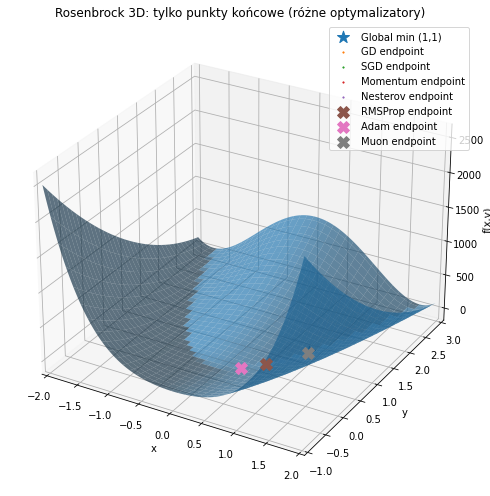

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Rosenbrock function + grad
# ----------------------------
def rosenbrock(x, a=1.0, b=100.0):
    X, Y = x[0], x[1]
    return (a - X)**2 + b*(Y - X**2)**2

def grad_rosenbrock(x, a=1.0, b=100.0):
    X, Y = x[0], x[1]
    dX = -2*(a - X) - 4*b*X*(Y - X**2)
    dY =  2*b*(Y - X**2)
    return np.array([dX, dY], dtype=float)

# ----------------------------
# Optimizers
# ----------------------------
def optimize(optimizer, x0, steps=8000, lr=1e-3, seed=0,
             noise_std=0.0,          # only for "SGD"-style
             beta=0.9,               # momentum / nesterov
             beta1=0.9, beta2=0.999, # adam
             rms_beta=0.99,          # rmsprop
             eps=1e-8,
             weight_decay=0.0):      # for AdamW (optional)
    rng = np.random.default_rng(seed)
    x = np.array(x0, dtype=float)

    v_mom = np.zeros_like(x)  # momentum velocity
    m = np.zeros_like(x)      # Adam first moment
    v = np.zeros_like(x)      # Adam second moment
    s = np.zeros_like(x)      # RMSProp second moment
    v_muon = np.zeros_like(x)  # Muon block momentum

    for t in range(1, steps + 1):
        # Choose gradient evaluation point (for Nesterov)
        if optimizer == "Nesterov":
            g = grad_rosenbrock(x - lr * beta * v_mom)
        else:
            g = grad_rosenbrock(x)

        # Optional "SGD noise" to imitate minibatch stochasticity
        if optimizer in ["SGD", "Momentum", "Nesterov"] and noise_std > 0:
            g = g + rng.normal(0.0, noise_std, size=2)

        if optimizer in ["GD", "SGD"]:
            x = x - lr * g

        elif optimizer == "Momentum":
            v_mom = beta * v_mom + (1 - beta) * g
            x = x - lr * v_mom

        elif optimizer == "Nesterov":
            v_mom = beta * v_mom + (1 - beta) * g
            x = x - lr * v_mom

        elif optimizer == "RMSProp":
            s = rms_beta * s + (1 - rms_beta) * (g * g)
            x = x - lr * g / (np.sqrt(s) + eps)

        elif optimizer == "Adam":
            m = beta1 * m + (1 - beta1) * g
            v = beta2 * v + (1 - beta2) * (g * g)
            m_hat = m / (1 - beta1**t)
            v_hat = v / (1 - beta2**t)
            x = x - lr * m_hat / (np.sqrt(v_hat) + eps)

        elif optimizer == "AdamW":
            # decoupled weight decay (simple demonstration)
            # (weight decay isn't super meaningful here, but included for completeness)
            m = beta1 * m + (1 - beta1) * g
            v = beta2 * v + (1 - beta2) * (g * g)
            m_hat = m / (1 - beta1**t)
            v_hat = v / (1 - beta2**t)
            x = x - lr * (m_hat / (np.sqrt(v_hat) + eps) + weight_decay * x)
        elif optimizer == "Muon":
            # Block-wise momentum
            v_muon = beta * v_muon + (1 - beta) * g

            # Block normalization (key Muon idea)
            norm = np.linalg.norm(v_muon)
            if norm > eps:
                direction = v_muon / norm
            else:
                direction = v_muon

            # Decoupled weight decay (optional but "correct")
            x = x - lr * direction - lr * weight_decay * x

        else:
            raise ValueError(f"Unknown optimizer: {optimizer}")

        # Safety: stop if diverged
        if not np.isfinite(x).all():
            return x * np.nan, np.nan

    return x, rosenbrock(x)

# ----------------------------
# Plot 3D + endpoints only
# ----------------------------
def demo_rosenbrock_3d_only_endpoints(
    x0=(1.5, -1.5),
    steps=1000,
    domain_x=(-2.0, 2.0),
    domain_y=(-1.0, 3.0)
):
    xs = np.linspace(domain_x[0], domain_x[1], 220)
    ys = np.linspace(domain_y[0], domain_y[1], 220)
    X, Y = np.meshgrid(xs, ys)
    Z = (1 - X)**2 + 100*(Y - X**2)**2

    # More stable learning rates
    results = []
    results.append(("GD",        *optimize("GD",        x0=x0, steps=steps, lr=1e-2)))
    results.append(("SGD",       *optimize("SGD",       x0=x0, steps=steps, lr=1e-2, noise_std=0.20, seed=1)))
    results.append(("Momentum",  *optimize("Momentum",  x0=x0, steps=steps, lr=1e-2, noise_std=0.10, seed=2, beta=0.9)))
    results.append(("Nesterov",  *optimize("Nesterov",  x0=x0, steps=steps, lr=1e-2, noise_std=0.10, seed=3, beta=0.9)))
    results.append(("RMSProp",   *optimize("RMSProp",   x0=x0, steps=steps, lr=1e-2, rms_beta=0.99)))
    results.append(("Adam",      *optimize("Adam",      x0=x0, steps=steps, lr=1e-2)))
    # Optional:
    # results.append(("AdamW",     *optimize("AdamW",     x0=x0, steps=steps, lr=2e-3, weight_decay=1e-2)))
    results.append(("Muon", *optimize(
        "Muon",
        x0=x0,
        steps=steps,
        lr=5e-3,        # Muon toleruje większy LR
        beta=0.9,
        weight_decay=1e-2
    )))

    print(f"Start x0 = {x0}")
    for name, x_end, f_end in results:
        print(f"{name:9s}: x_end=({x_end[0]: .6f}, {x_end[1]: .6f})  f={f_end: .6f}")

    fig = plt.figure(figsize=(11, 7))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(X, Y, Z, rstride=6, cstride=6, linewidth=0, antialiased=True, alpha=0.65)

    ax.scatter(1.0, 1.0, 0.0, s=160, marker="*", label="Global min (1,1)")

    for name, x_end, f_end in results:
        ax.scatter(x_end[0], x_end[1], f_end, s=140, marker="X", label=f"{name} endpoint")

    ax.set_title("Rosenbrock 3D: tylko punkty końcowe (różne optymalizatory)")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("f(x,y)")
    ax.set_xlim(domain_x)
    ax.set_ylim(domain_y)
    ax.view_init(elev=28, azim=-60)
    ax.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    demo_rosenbrock_3d_only_endpoints()



# Tutaj mamy ładny przykład dla tego samego learning rate 1e-2, zmieniłem punkt startowy, jak zbieżność metod nam się poprawiła dla 1000 kroków 

/tmp/ipykernel_17566/3774533436.py:13: RuntimeWarning: overflow encountered in double_scalars
  dX = -2*(a - X) - 4*b*X*(Y - X**2)
/tmp/ipykernel_17566/3774533436.py:14: RuntimeWarning: overflow encountered in double_scalars
  dY =  2*b*(Y - X**2)


Start x0 = (1.5, 1.5)
GD       : x_end=( nan,  nan)  f= nan
SGD      : x_end=( nan,  nan)  f= nan
Momentum : x_end=( 0.989868,  0.979109)  f= 0.000156
Nesterov : x_end=( 1.000560,  1.001004)  f= 0.000002
RMSProp  : x_end=( 1.006236,  1.027654)  f= 0.022970
Adam     : x_end=( 1.100681,  1.211784)  f= 0.010145
Muon     : x_end=( 0.995767,  0.975576)  f= 0.025543


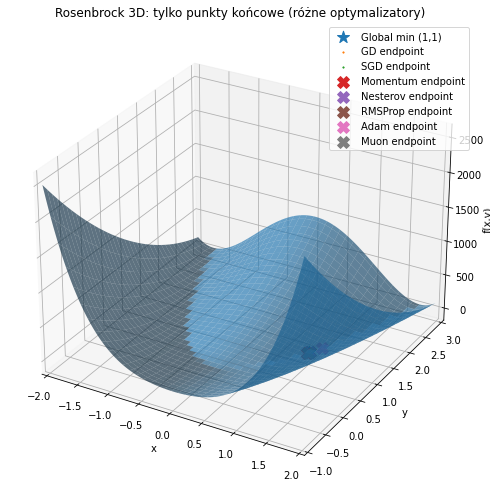

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Rosenbrock function + grad
# ----------------------------
def rosenbrock(x, a=1.0, b=100.0):
    X, Y = x[0], x[1]
    return (a - X)**2 + b*(Y - X**2)**2

def grad_rosenbrock(x, a=1.0, b=100.0):
    X, Y = x[0], x[1]
    dX = -2*(a - X) - 4*b*X*(Y - X**2)
    dY =  2*b*(Y - X**2)
    return np.array([dX, dY], dtype=float)

# ----------------------------
# Optimizers
# ----------------------------
def optimize(optimizer, x0, steps=8000, lr=1e-3, seed=0,
             noise_std=0.0,          # only for "SGD"-style
             beta=0.9,               # momentum / nesterov
             beta1=0.9, beta2=0.999, # adam
             rms_beta=0.99,          # rmsprop
             eps=1e-8,
             weight_decay=0.0):      # for AdamW (optional)
    rng = np.random.default_rng(seed)
    x = np.array(x0, dtype=float)

    v_mom = np.zeros_like(x)  # momentum velocity
    m = np.zeros_like(x)      # Adam first moment
    v = np.zeros_like(x)      # Adam second moment
    s = np.zeros_like(x)      # RMSProp second moment
    v_muon = np.zeros_like(x)  # Muon block momentum

    for t in range(1, steps + 1):
        # Choose gradient evaluation point (for Nesterov)
        if optimizer == "Nesterov":
            g = grad_rosenbrock(x - lr * beta * v_mom)
        else:
            g = grad_rosenbrock(x)

        # Optional "SGD noise" to imitate minibatch stochasticity
        if optimizer in ["SGD", "Momentum", "Nesterov"] and noise_std > 0:
            g = g + rng.normal(0.0, noise_std, size=2)

        if optimizer in ["GD", "SGD"]:
            x = x - lr * g

        elif optimizer == "Momentum":
            v_mom = beta * v_mom + (1 - beta) * g
            x = x - lr * v_mom

        elif optimizer == "Nesterov":
            v_mom = beta * v_mom + (1 - beta) * g
            x = x - lr * v_mom

        elif optimizer == "RMSProp":
            s = rms_beta * s + (1 - rms_beta) * (g * g)
            x = x - lr * g / (np.sqrt(s) + eps)

        elif optimizer == "Adam":
            m = beta1 * m + (1 - beta1) * g
            v = beta2 * v + (1 - beta2) * (g * g)
            m_hat = m / (1 - beta1**t)
            v_hat = v / (1 - beta2**t)
            x = x - lr * m_hat / (np.sqrt(v_hat) + eps)

        elif optimizer == "AdamW":
            # decoupled weight decay (simple demonstration)
            # (weight decay isn't super meaningful here, but included for completeness)
            m = beta1 * m + (1 - beta1) * g
            v = beta2 * v + (1 - beta2) * (g * g)
            m_hat = m / (1 - beta1**t)
            v_hat = v / (1 - beta2**t)
            x = x - lr * (m_hat / (np.sqrt(v_hat) + eps) + weight_decay * x)
        elif optimizer == "Muon":
            # Block-wise momentum
            v_muon = beta * v_muon + (1 - beta) * g

            # Block normalization (key Muon idea)
            norm = np.linalg.norm(v_muon)
            if norm > eps:
                direction = v_muon / norm
            else:
                direction = v_muon

            # Decoupled weight decay (optional but "correct")
            x = x - lr * direction - lr * weight_decay * x

        else:
            raise ValueError(f"Unknown optimizer: {optimizer}")

        # Safety: stop if diverged
        if not np.isfinite(x).all():
            return x * np.nan, np.nan

    return x, rosenbrock(x)

# ----------------------------
# Plot 3D + endpoints only
# ----------------------------
def demo_rosenbrock_3d_only_endpoints(
    x0=(1.5, 1.5),
    steps=3000,
    domain_x=(-2.0, 2.0),
    domain_y=(-1.0, 3.0)
):
    xs = np.linspace(domain_x[0], domain_x[1], 220)
    ys = np.linspace(domain_y[0], domain_y[1], 220)
    X, Y = np.meshgrid(xs, ys)
    Z = (1 - X)**2 + 100*(Y - X**2)**2

    # More stable learning rates
    results = []
    results.append(("GD",        *optimize("GD",        x0=x0, steps=steps, lr=1e-2)))
    results.append(("SGD",       *optimize("SGD",       x0=x0, steps=steps, lr=1e-2, noise_std=0.20, seed=1)))
    results.append(("Momentum",  *optimize("Momentum",  x0=x0, steps=steps, lr=1e-2, noise_std=0.10, seed=2, beta=0.9)))
    results.append(("Nesterov",  *optimize("Nesterov",  x0=x0, steps=steps, lr=1e-2, noise_std=0.10, seed=3, beta=0.9)))
    results.append(("RMSProp",   *optimize("RMSProp",   x0=x0, steps=steps, lr=1e-2, rms_beta=0.99)))
    results.append(("Adam",      *optimize("Adam",      x0=x0, steps=steps, lr=1e-2)))
    # Optional:
    # results.append(("AdamW",     *optimize("AdamW",     x0=x0, steps=steps, lr=2e-3, weight_decay=1e-2)))
    results.append(("Muon", *optimize(
        "Muon",
        x0=x0,
        steps=steps,
        lr=5e-3,        # Muon toleruje większy LR
        beta=0.9,
        weight_decay=1e-2
    )))

    print(f"Start x0 = {x0}")
    for name, x_end, f_end in results:
        print(f"{name:9s}: x_end=({x_end[0]: .6f}, {x_end[1]: .6f})  f={f_end: .6f}")

    fig = plt.figure(figsize=(11, 7))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(X, Y, Z, rstride=6, cstride=6, linewidth=0, antialiased=True, alpha=0.65)

    ax.scatter(1.0, 1.0, 0.0, s=160, marker="*", label="Global min (1,1)")

    for name, x_end, f_end in results:
        ax.scatter(x_end[0], x_end[1], f_end, s=140, marker="X", label=f"{name} endpoint")

    ax.set_title("Rosenbrock 3D: tylko punkty końcowe (różne optymalizatory)")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("f(x,y)")
    ax.set_xlim(domain_x)
    ax.set_ylim(domain_y)
    ax.view_init(elev=28, azim=-60)
    ax.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    demo_rosenbrock_3d_only_endpoints()

